In [1]:
# use seastar Kernel on adrien local laptop

# import os
import xarray as xr
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # => to add in Seastar env
import seastar
from seastar.utils.tools import dotdict
from seastar.performance import scene_generation

from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares

# from seastar.gmfs.doppler import *

In [2]:
# % Antennae
# % Main parameters from the EE11 proposal                                        
                                                                                
# % geometry                                                                      
inc_angle_mid_propa  = [20.0; 28.4; 33.4];                                      
inc_angle_sqt_propa  = [31.5; 36.5; 40.0];                                      
squint_ground_propa  = [37.8; 52.2]; % from the North/sat direction; 90-x for sqt from mid
                                                                                
# % Resolution                                                                    
mid_range_resolution = 28; % in meter                                           
mid_azimuth_resolution = 20; % in meter                                         
sqt_range_resolution = 28; % in meter                                           
sqt_azimuth_resolution = 20; % in meter                                         
                                                                                
# % Noise                                                                         
NESZ_sqt_NearSwath_propa   = [-26; -28; -26]; % @inci [20; 24.2; 28.4-]         
NESZ_sqt_FarSwath_propa    = [-27; -28; -27]; % @inci [28.4+; 30.9; 33.4]       
NESZ_mid_NearSwath_propa   = [-20; -26; -20]; % @inci [20; 24.2; 28.4-]         
NESZ_mid_FarSwath_propa   = [-26; -28; -26]; % @inci [28.4+; 30.9; 33.4]        
                                                                                
# % Interpolation over squint inci angle                                          
inc_angle_sqt  = [31.5; 34.0; 36.0; 37.0; 38.5; 40.0];                          
inc_angle_mid  = interp1(inc_angle_sqt_propa, inc_angle_mid_propa, inc_angle_sqt, 'linear');
squint_ground  = interp1(inc_angle_sqt_propa([1, end]), squint_ground_propa, inc_angle_sqt, 'linear');
NESZ_sqt       = interp1([linspace(inc_angle_sqt_propa(1), inc_angle_sqt_propa(2)-0.001, 3),...
                           linspace(inc_angle_sqt_propa(2), inc_angle_sqt_propa(3), 3)],...
                           [NESZ_sqt_NearSwath_propa', NESZ_sqt_FarSwath_propa'],...
                           inc_angle_sqt, 'linear');                            
NESZ_mid       = interp1([linspace(inc_angle_sqt_propa(1), inc_angle_sqt_propa(2)-0.001, 3),...
                           linspace(inc_angle_sqt_propa(2), inc_angle_sqt_propa(3), 3)],...
                           [NESZ_mid_NearSwath_propa', NESZ_mid_FarSwath_propa'],...
                           inc_angle_sqt, 'linear');                            
                                                                                
# % Along track Interferometry Baseline                                           
Vp = 7.4 * 1000; % in m/s                                                       
Baseline_phy = 15; % in meter                                                   
                                                                                
# % NRCS GMF name                                                                 
NRCS_GMF.name = 'NSCAT1';     

SyntaxError: invalid syntax (3239496455.py, line 5)

# 1/ Test with constant Inci, Squint, Noise, ...

In [2]:
inst = xr.Dataset(
    data_vars=dict(
        CentralWavenumber=( [],270 ),# TODO this should be calculated if needed from CentralFreq, not put as an input
        CentralFreq=( [], 13.5 * 10**9 ),
        IncidenceAngleImage=( ['across','Antenna'], np.full([5,4], 30) ),
        AntennaAzimuthImage=(['across', 'Antenna'],
                           np.stack((np.full([5], 45),
                                     np.full([5], 90),
                                     np.full([5], 90),
                                     np.full([5], 135)
                                     ), axis=-1
                                    )
                           ),
        Polarization=(['across','Antenna'],
                          np.stack((np.full([5,], 'VV'),
                                    np.full([5,], 'VV'),
                                    np.full([5,], 'HH'),
                                    np.full([5,], 'VV')
                                    ), axis=-1
                                   )
                          ),
    ),
    coords=dict(
            across=np.arange(0,5),
            Antenna=['Fore','MidV','MidH','Aft'],
        ),
)
inst = inst.set_coords([
    'CentralWavenumber',
    'CentralFreq',
#     'IncidenceAngleImage',
#     'AntennaAzimuthImage',
#     'Polarization', 
])
inst

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4)
Coordinates:
    CentralWavenumber    int64 270
    CentralFreq          float64 1.35e+10
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
Data variables:
    IncidenceAngleImage  (across, Antenna) int64 30 30 30 30 30 ... 30 30 30 30
    AntennaAzimuthImage  (across, Antenna) int64 45 90 90 135 ... 45 90 90 135
    Polarization         (across, Antenna) <U2 'VV' 'VV' 'HH' ... 'VV' 'HH' 'VV'

In [3]:
# along = xr.Dataset(coords={'along': np.arange(0,6)})

# level1 = inst * along # cf https://github.com/pydata/xarray/discussions/6163

In [5]:
geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['across', 'along'], np.full([5, 6], 10)),
            WindDirection=(['across', 'along'], np.full([5, 6], 150)),
            CurrentVelocity=(['across', 'along'], np.full([5, 6], 1)),
            CurrentDirection=(['across', 'along'], np.full([5, 6], 150)),
        ),
        coords=dict(
            across=np.arange(0, 5),
            along=np.arange(0, 6),
        ),
    )
geo

<xarray.Dataset>
Dimensions:           (across: 5, along: 6)
Coordinates:
  * across            (across) int64 0 1 2 3 4
  * along             (along) int64 0 1 2 3 4 5
Data variables:
    WindSpeed         (across, along) int64 10 10 10 10 10 10 ... 10 10 10 10 10
    WindDirection     (across, along) int64 150 150 150 150 ... 150 150 150 150
    CurrentVelocity   (across, along) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    CurrentDirection  (across, along) int64 150 150 150 150 ... 150 150 150 150

In [6]:
truth = xr.broadcast(inst, geo)[0]
truth

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4, along: 6)
Coordinates:
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int64 270
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
  * along                (along) int64 0 1 2 3 4 5
Data variables:
    IncidenceAngleImage  (across, Antenna, along) int64 30 30 30 30 ... 30 30 30
    AntennaAzimuthImage  (across, Antenna, along) int64 45 45 45 ... 135 135 135
    Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'

In [7]:
gmf=dotdict({
    'nrcs': dotdict({'name': 'nscat4ds'}),
    'doppler': dotdict({'name': 'mouche12'}),
})

In [8]:
# TODO add the broadcast to create truth in the truth_fct
truth = scene_generation.truth_fct(geo, truth, gmf)
truth

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4, along: 6)
Coordinates:
    IncidenceAngleImage  (across, Antenna, along) int64 30 30 30 30 ... 30 30 30
    AntennaAzimuthImage  (across, Antenna, along) int64 45 45 45 ... 135 135 135
    Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int64 270
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
  * along                (along) int64 0 1 2 3 4 5
Data variables:
    WindSpeed            (across, along) int64 10 10 10 10 10 ... 10 10 10 10 10
    WindDirection        (across, along) int64 150 150 150 150 ... 150 150 150
    CurrentVelocity      (across, along) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    CurrentDirection     (across, along) int64 150 150 150 150 ... 150 150 150
    Sigma0               (Antenna, across, along) float64 0.07121 ... 0.1666
    RVL                  (Antenna, across, along) float64 0.06358 ... -0.5307

In [24]:
# should build a class uncertainty, to check the inputs and calculate the other ones

# uncertainty=dotdict({ # should build a class uncertainty, to check the inputs and calculate the other ones
# #     'N': float, ndarray,
# #     'NESZ': float, ndarray,
#     'Kp': [0.03, 0.03, 0.04, 0.04],  # float, ndarray,
# #     'Kp_gen': float, ndarray,
# #     'Sigma0': # float, ndarray, = truth * Kp
#     'RVL': 0.05, # projected on the surface m/s
# })
# # for SEASTAR EE1 proposal it was used NESZ + N

uncertainty_in = xr.Dataset(
    data_vars=dict(
        Kp=( ['Antenna'], np.array([0.03, 0.05, 0.05, 0.03])),
        RVL=( ['Antenna'], np.array([0.05, 0.20, 0.20, 0.05])),
    ),
    coords=dict(
            Antenna=['Fore','MidV','MidH','Aft'],
        ),
)
uncertainty_in

# TODO this should be directly defined in the "inst" characteristics


<xarray.Dataset>
Dimensions:  (Antenna: 4)
Coordinates:
  * Antenna  (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
Data variables:
    Kp       (Antenna) float64 0.03 0.05 0.05 0.03
    RVL      (Antenna) float64 0.05 0.2 0.2 0.05

In [10]:
[uncertainty, noise] = scene_generation.uncertainty_fct(truth, uncertainty_in)
uncertainty, noise

To Be Done - uncertainty function


(<xarray.Dataset>
 Dimensions:              (Antenna: 4, across: 5, along: 6)
 Coordinates:
   * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
     IncidenceAngleImage  (across, Antenna, along) int64 30 30 30 30 ... 30 30 30
     AntennaAzimuthImage  (across, Antenna, along) int64 45 45 45 ... 135 135 135
     Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'
     CentralFreq          float64 1.35e+10
     CentralWavenumber    int64 270
   * across               (across) int64 0 1 2 3 4
   * along                (along) int64 0 1 2 3 4 5
 Data variables:
     Kp                   (Antenna) float64 0.03 0.05 0.05 0.03
     RVL                  (Antenna) float64 0.05 0.2 0.2 0.05
     Sigma0               (Antenna, across, along) float64 0.002136 ... 0.004999,
 <xarray.Dataset>
 Dimensions:              (Antenna: 4, across: 5, along: 6)
 Coordinates:
   * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
     AntennaAzimuthImage  (acros

In [11]:
level1 = scene_generation.noise_generation(truth, noise)
level1

In [18]:
%%time
##### WARNING ####### Take Time to compute #######
ambiguity = 'sort_by_cost'
level2, lmout = seastar.retrieval.level2.wind_current_retrieval(level1, noise, gmf, ambiguity)

To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambigui

In [19]:
level2

<xarray.Dataset>
Dimensions:            (across: 5, along: 6, x_variables: 4)
Coordinates:
  * across             (across) int64 0 1 2 3 4
  * along              (along) int64 0 1 2 3 4 5
  * x_variables        (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
    CentralFreq        float64 1.35e+10
    CentralWavenumber  int64 270
Data variables:
    x                  (x_variables, across, along) float64 -4.428 ... -0.8098
    CurrentU           (across, along) float64 0.5711 0.4964 ... 0.4856 0.5447
    CurrentV           (across, along) float64 -0.815 -0.8799 ... -0.919 -0.8098
    WindU              (across, along) float64 -4.428 -4.484 ... -4.342 -4.41
    WindV              (across, along) float64 7.829 7.575 7.974 ... 7.899 7.871
    CurrentVelocity    (across, along) float64 0.9952 1.01 ... 1.039 0.976
    CurrentDirection   (across, along) float64 145.0 150.6 157.2 ... 152.1 146.1
    WindSpeed          (across, along) float64 8.995 8.803 8.985 ... 9.013 9.022
    WindDirection      (across, along) float64 145.0 150.6 157.2 ... 152.1 146.1

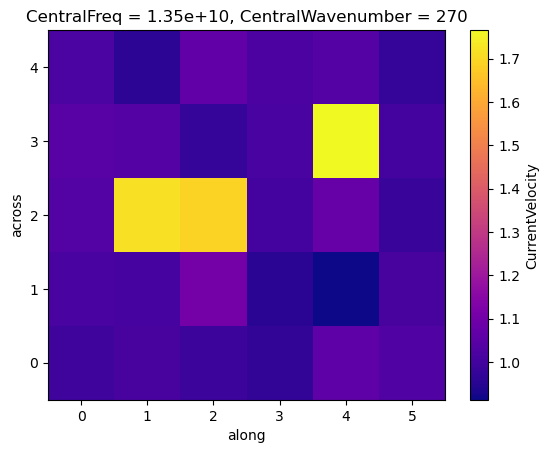

In [41]:
level2.CurrentVelocity.plot(cmap='plasma')

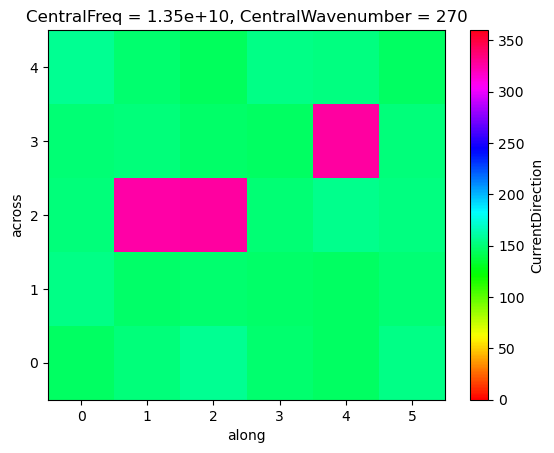

In [33]:
level2.CurrentDirection.plot(cmap='hsv', vmin=0, vmax=360)

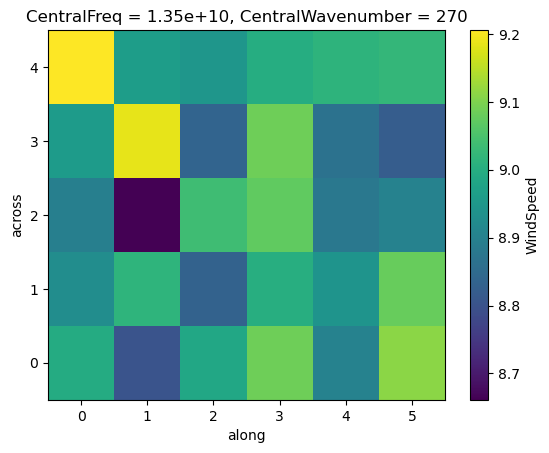

In [43]:
level2.WindSpeed.plot(cmap='viridis')

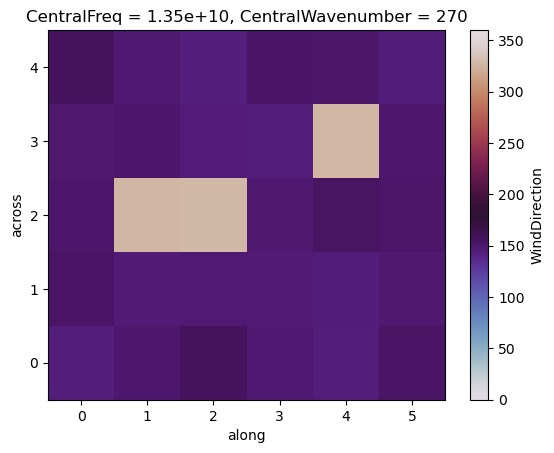

In [42]:
level2.WindDirection.plot(cmap='twilight', vmin=0, vmax=360)

In [29]:
inst

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4)
Coordinates:
    CentralWavenumber    int64 270
    CentralFreq          float64 1.35e+10
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
Data variables:
    IncidenceAngleImage  (across, Antenna) int64 30 30 30 30 30 ... 30 30 30 30
    AntennaAzimuthImage  (across, Antenna) int64 45 90 90 135 ... 45 90 90 135
    Polarization         (across, Antenna) <U2 'VV' 'VV' 'HH' ... 'VV' 'HH' 'VV'

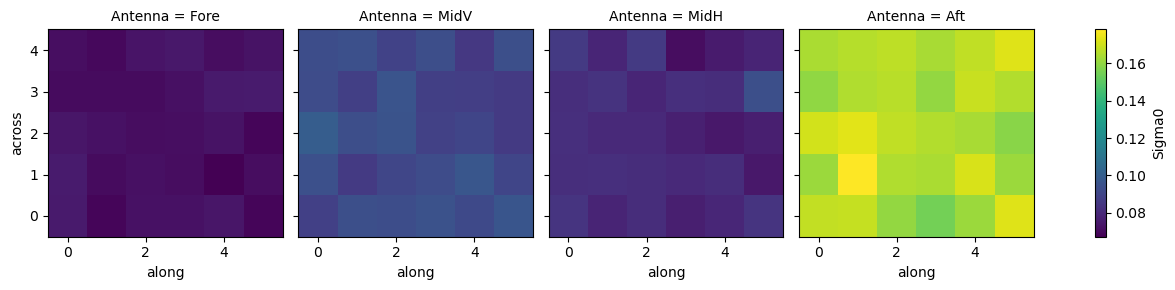

In [21]:
level1.Sigma0.plot(col='Antenna')

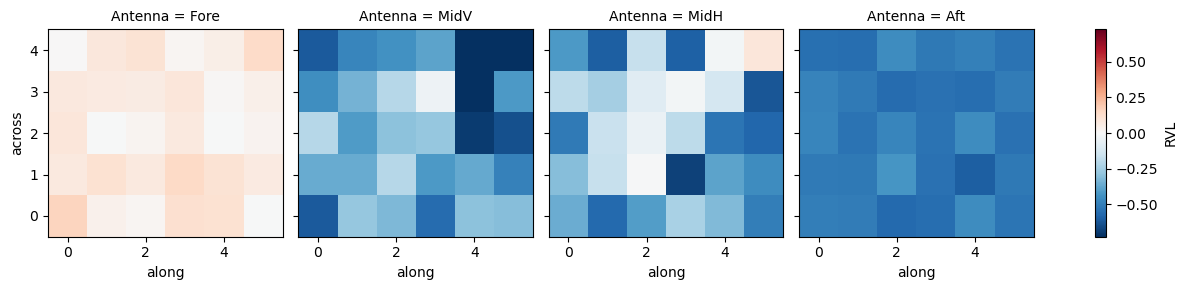

In [15]:
level1.RVL.plot(col='Antenna')

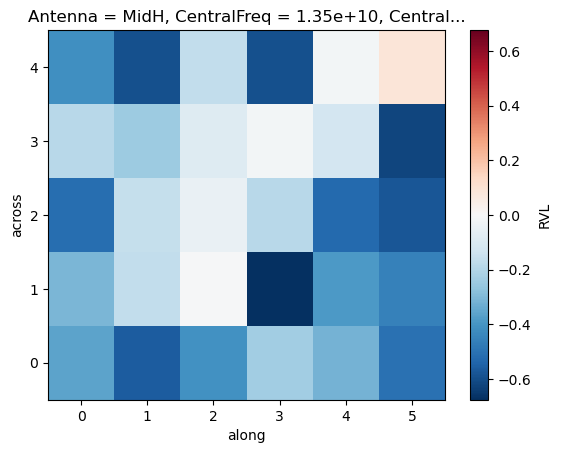

In [17]:
level1.RVL.sel(Antenna='MidH').plot()

In [40]:
# Add NaN for RVL for the mid antennas
level1.RVL[1,:,:] = np.full([5,6], np.nan)
level1.RVL[2,:,:] = np.full([5,6], np.nan)


# 2/ Test with constant Inci, Squint, Noise, ...

In [2]:
# Antennas main parameters
# geometry
inc_angle_mid_propa = [20.0, 28.4, 33.4]
inc_angle_sqt_propa = [31.5, 36.5, 40.0]
sqt_ground_propa = [37.8, 45.0, 52.2] # defined from sat direction for Fore beam;
# relation functions with mid inci angle
f_inc_sqt = interpolate.interp1d(inc_angle_mid_propa, inc_angle_sqt_propa, fill_value='extrapolate')
f_squint_ground = interpolate.interp1d(inc_angle_mid_propa, sqt_ground_propa, fill_value='extrapolate')
# interpolation over mid inci angle
inc_angle_mid = np.arange(15, 35+1, 2) # <- where to change the across length
inc_angle_sqt = f_inc_sqt(inc_angle_mid)
squint_ground = f_squint_ground(inc_angle_mid)

In [3]:
across = np.arange(0,len(inc_angle_mid))

inst2 = xr.Dataset(
    data_vars=dict(
        CentralWavenumber=( [],270 ),# TODO this should be calculated if needed from CentralFreq, not put as an input
        CentralFreq=( [], 13.5 * 10**9 ),
        IncidenceAngleImage=( ['across','Antenna'], 
                             np.stack((
                                 inc_angle_sqt,
                                 inc_angle_mid,
                                 inc_angle_mid,
                                 inc_angle_sqt,
                             ), axis=-1)
                            ),
        AntennaAzimuthImage=( ['across', 'Antenna'],
                             np.stack((
                                 squint_ground,
                                 np.full([across.size], 90),
                                 np.full([across.size], 90),
                                 180 - squint_ground,
                             ), axis=-1)
                           ),
        Polarization=(['across','Antenna'],
                          np.stack((np.full([across.size,], 'VV'),
                                    np.full([across.size,], 'VV'),
                                    np.full([across.size,], 'HH'),
                                    np.full([across.size,], 'VV')
                                    ), axis=-1
                                   )
                          ),
    ),
    coords=dict(
            across=across,
            Antenna=['Fore','MidV','MidH','Aft'],
        ),
)
inst2 = inst2.set_coords([
    'CentralWavenumber',
    'CentralFreq',
])
inst2

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4)
Coordinates:
    CentralWavenumber    int64 270
    CentralFreq          float64 1.35e+10
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
Data variables:
    IncidenceAngleImage  (across, Antenna) float64 28.52 15.0 ... 35.0 41.12
    AntennaAzimuthImage  (across, Antenna) float64 33.51 90.0 ... 90.0 125.5
    Polarization         (across, Antenna) <U2 'VV' 'VV' 'HH' ... 'VV' 'HH' 'VV'

In [34]:
along = np.arange(0, 9)

geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['across', 'along'], np.full([across.size, along.size], 5)),
            WindDirection=(['across', 'along'], np.full([across.size, along.size], 270)),
            CurrentVelocity=(['across', 'along'], np.full([across.size, along.size], 0.6)),
            CurrentDirection=(['across', 'along'], np.full([across.size, along.size], 150)),
        ),
        coords=dict(
            across=across,
            along=along,
        ),
    )
geo

<xarray.Dataset>
Dimensions:           (across: 5, along: 9)
Coordinates:
  * across            (across) int64 0 1 2 3 4
  * along             (along) int64 0 1 2 3 4 5 6 7 8
Data variables:
    WindSpeed         (across, along) int64 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5
    WindDirection     (across, along) int64 270 270 270 270 ... 270 270 270 270
    CurrentVelocity   (across, along) float64 0.6 0.6 0.6 0.6 ... 0.6 0.6 0.6
    CurrentDirection  (across, along) int64 150 150 150 150 ... 150 150 150 150

In [35]:
gmf=dotdict({
    'nrcs': dotdict({'name': 'nscat4ds'}),
    'doppler': dotdict({'name': 'mouche12'}),
})

In [36]:
# TODO add the broadcast to create truth in the truth_fct
truth = scene_generation.truth_fct(geo, inst2, gmf)
truth

<xarray.Dataset>
Dimensions:              (across: 5, Antenna: 4, along: 9)
Coordinates:
    IncidenceAngleImage  (across, Antenna, along) float64 28.52 28.52 ... 41.12
    AntennaAzimuthImage  (across, Antenna, along) float64 33.51 33.51 ... 125.5
    Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int64 270
  * across               (across) int64 0 1 2 3 4
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
  * along                (along) int64 0 1 2 3 4 5 6 7 8
Data variables:
    Sigma0               (Antenna, across, along) float64 0.0369 ... 0.005742
    RSV                  (Antenna, across, along) float64 0.2572 ... 0.9744
    WindSpeed            (across, along) int64 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5
    WindDirection        (across, along) int64 270 270 270 270 ... 270 270 270
    CurrentVelocity      (across, along) float64 0.6 0.6 0.6 0.6 ... 0.6 0.6 0.6
    CurrentDirection     (across, along) int64 150 150 150 150 ... 150 150 150
Attributes:
    gmf:      {'nrcs': {'name': 'nscat4ds'}, 'doppler': {'name': 'mouche12'}}

In [37]:
# should build a class uncertainty, to check the inputs and calculate the other ones

# uncertainty=dotdict({ # should build a class uncertainty, to check the inputs and calculate the other ones
# #     'N': float, ndarray,
# #     'NESZ': float, ndarray,
#     'Kp': [0.03, 0.03, 0.04, 0.04],  # float, ndarray,
# #     'Kp_gen': float, ndarray,
# #     'Sigma0': # float, ndarray, = truth * Kp
#     'RVL': 0.05, # projected on the surface m/s
# })
# # for SEASTAR EE1 proposal it was used NESZ + N

uncertainty_in = xr.Dataset(
    data_vars=dict(
        Kp=( ['Antenna'], np.array([0.03, 0.05, 0.05, 0.03])),
        RSV=( ['Antenna'], np.array([0.05, 0.20, 0.20, 0.05])),
    ),
    coords=dict(
            Antenna=['Fore','MidV','MidH','Aft'],
        ),
)
uncertainty_in

# TODO this should be directly defined in the "inst" characteristics


<xarray.Dataset>
Dimensions:  (Antenna: 4)
Coordinates:
  * Antenna  (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
Data variables:
    Kp       (Antenna) float64 0.03 0.05 0.05 0.03
    RSV      (Antenna) float64 0.05 0.2 0.2 0.05

In [38]:
[uncertainty, noise] = scene_generation.uncertainty_fct(truth, uncertainty_in)
uncertainty, noise

To Be Done - uncertainty function


(<xarray.Dataset>
 Dimensions:              (Antenna: 4, across: 5, along: 9)
 Coordinates:
   * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
     IncidenceAngleImage  (across, Antenna, along) float64 28.52 28.52 ... 41.12
     AntennaAzimuthImage  (across, Antenna, along) float64 33.51 33.51 ... 125.5
     Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'
     CentralFreq          float64 1.35e+10
     CentralWavenumber    int64 270
   * across               (across) int64 0 1 2 3 4
   * along                (along) int64 0 1 2 3 4 5 6 7 8
 Data variables:
     Kp                   (Antenna) float64 0.03 0.05 0.05 0.03
     RSV                  (Antenna) float64 0.05 0.2 0.2 0.05
     Sigma0               (Antenna, across, along) float64 0.001107 ... 0.0001723,
 <xarray.Dataset>
 Dimensions:              (Antenna: 4, across: 5, along: 9)
 Coordinates:
   * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
     AntennaAzimuthImage  (

In [39]:
level1 = scene_generation.noise_generation(truth, noise)
level1

<xarray.Dataset>
Dimensions:              (Antenna: 4, across: 5, along: 9)
Coordinates:
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'MidH' 'Aft'
    AntennaAzimuthImage  (across, Antenna, along) float64 33.51 33.51 ... 125.5
    Polarization         (across, Antenna, along) <U2 'VV' 'VV' ... 'VV' 'VV'
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int64 270
  * across               (across) int64 0 1 2 3 4
  * along                (along) int64 0 1 2 3 4 5 6 7 8
    IncidenceAngleImage  (across, Antenna, along) float64 28.52 28.52 ... 41.12
Data variables:
    Sigma0               (Antenna, across, along) float64 0.03774 ... 0.005799
    RSV                  (Antenna, across, along) float64 0.2681 ... 1.009

In [ ]:
%%time
##### WARNING ####### Take Time to compute #######
ambiguity = 'sort_by_cost'
level2, lmout = seastar.retrieval.level2.wind_current_retrieval(level1, noise, gmf, ambiguity)

To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambiguity_sort_by_cost
To Be Done - solve_ambiguity
To Be Done find_initial_value
To Be Done - ambigui

In [17]:
level2


<xarray.Dataset>
Dimensions:            (across: 5, along: 6, x_variables: 4)
Coordinates:
  * across             (across) int64 0 1 2 3 4
  * along              (along) int64 0 1 2 3 4 5
  * x_variables        (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
    CentralFreq        float64 1.35e+10
    CentralWavenumber  int64 270
Data variables:
    x                  (x_variables, across, along) float64 -4.888 ... -0.8058
    CurrentU           (across, along) float64 0.6251 0.4594 ... 0.405 0.5133
    CurrentV           (across, along) float64 -0.8637 -0.8561 ... -0.8058
    WindU              (across, along) float64 -4.888 -4.857 ... -4.39 -4.529
    WindV              (across, along) float64 7.605 7.792 8.045 ... 7.839 7.694
    CurrentVelocity    (across, along) float64 1.066 0.9716 ... 0.9207 0.9554
    CurrentDirection   (across, along) float64 144.1 151.8 160.4 ... 153.9 147.5
    WindSpeed          (across, along) float64 9.04 9.182 8.719 ... 8.985 8.928
    WindDirection      (across, along) float64 144.1 151.8 160.4 ... 153.9 147.5

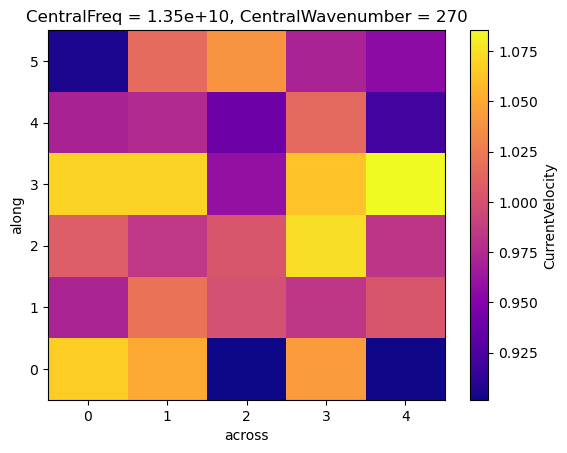

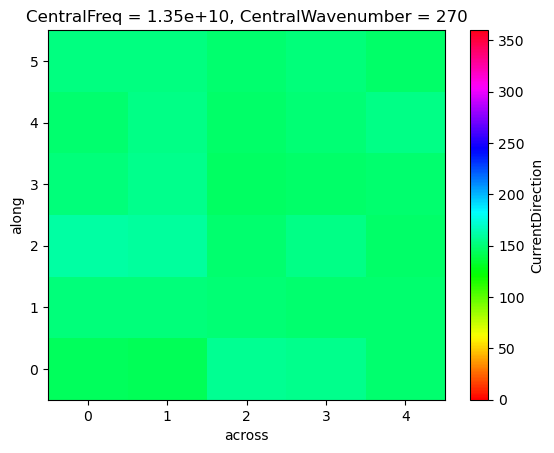

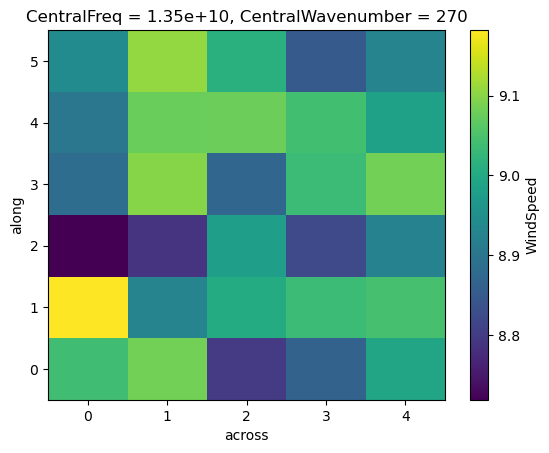

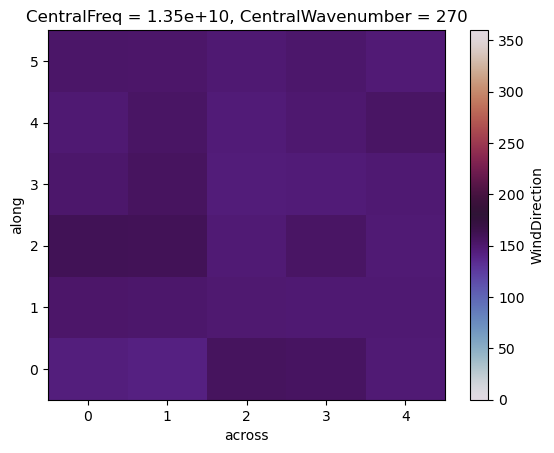

In [27]:
cmap_dict = {'CurrentVelocity': 'plasma', 'CurrentDirection': 'hsv', 'WindSpeed': 'viridis', 'WindDirection': 'twilight'}
clim_dict = {'CurrentDirection': [0, 360], 'WindDirection': [0, 360]}
for var in cmap_dict.keys():
    plt.figure()
    if var in clim_dict:
        level2[var].plot(cmap=cmap_dict[var], x='across', vmin=clim_dict[var][0], vmax=clim_dict[var][1])
    else:
        level2[var].plot(cmap=cmap_dict[var], x='across')
            

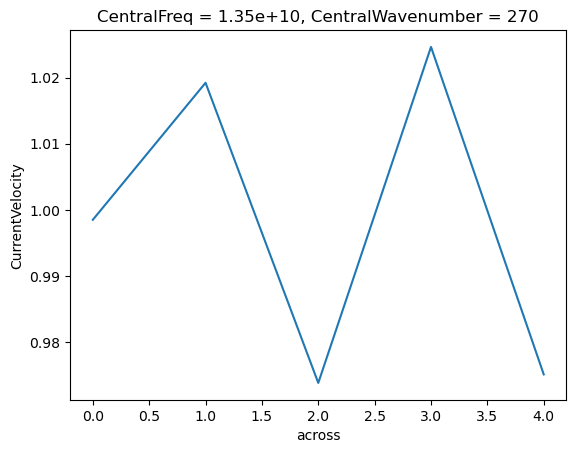

In [28]:
level2.CurrentVelocity.mean(dim='along').plot()

In [33]:
level2.CurrentVelocity.std(dim='along').sel(Antenna='MidV').plot(x='IncidenceAngle')

KeyError: "'Antenna' is not a valid dimension or coordinate"